In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

# Tuto of package grb_afterglow_sim

# Load the package

In [3]:
from pyGRBaglow.synchrotron_model import fireball_afterglow as grb
import pyGRBaglow.constants as cc

## GRB parameters for the fireball model

In [4]:
redshift = 3.92
n0 = 258.08
eps_b = 0.0272
eps_e = 0.547
E_iso = 4.41e53
eta=0.77
p=2.68  #>2
Y=0
ism_type=0

# number of threads to use
num_threads = 4

## Compute SED at given times

In [5]:
wavelength=np.logspace(-7,12,1e4) #in angstroms
time = np.array([30/86400,10/1440,1/24,1]) # in days

frequencies = 3e8 / (wavelength*1e-10)

#Load object
afterglow=grb(n0, eps_b, eps_e, E_iso, eta, p, Y, redshift, ism_type, disp=0)
#Compute light curve
afterglow_lc=afterglow.light_curve(time, frequencies, num_threads)

In [6]:
labels=['30s','10m','1h','1j']
colors=['blue','green','red','black']

<IPython.core.display.Javascript object>


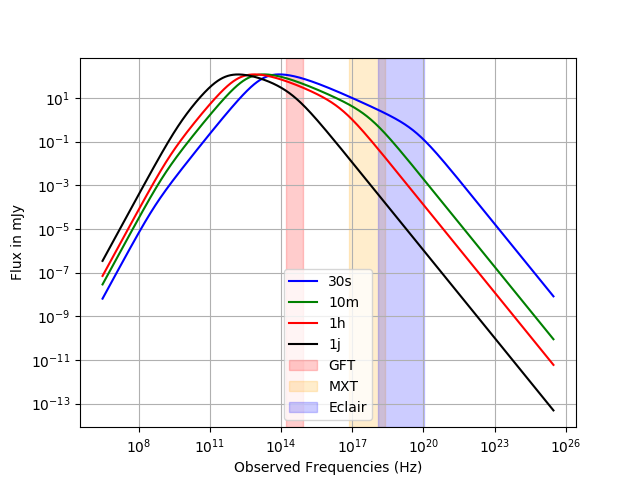

In [7]:
#Plot afterglow SED
plt.figure()
for i,t in enumerate(time):
    plt.plot(frequencies,afterglow_lc[i,:],label=labels[i],color=colors[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed Frequencies (Hz)') 
plt.ylabel(r'Flux in mJy')
plt.grid(True)
# shaded area for some of SVOM instruments coverage
plt.axvspan(cc.c_light_m_s*1e9/(350), cc.c_light_m_s*1e9/(1850),color='red', alpha=0.2,label="GFT")
plt.axvspan(0.3*1e3*cc.e_elec/(cc.H_planck), 10*1e3*cc.e_elec/(cc.H_planck), color='orange', alpha=0.2,label="MXT")
plt.axvspan(5e3*cc.e_elec/(cc.H_planck), 450e3*cc.e_elec/(cc.H_planck), color='blue', alpha=0.2,label="Eclair")

plt.legend(loc='best')


## Compute Light curve at given frequencies

In [8]:
wavelength=np.array([0.08,2.5,4500,16000]) #in angstroms
time = np.logspace(-5,7,1e4) # in days

frequencies = 3e8 / (wavelength*1e-10)

#Load object
afterglow=grb(n0, eps_b, eps_e, E_iso, eta, p, Y, redshift, ism_type, disp=0)
#Compute light curve for each time
afterglow_lc=afterglow.light_curve(time, frequencies, num_threads)

In [9]:
labels=['Eclair','MXT','g band','H band']
colors=['blue','green','red','black']

<IPython.core.display.Javascript object>


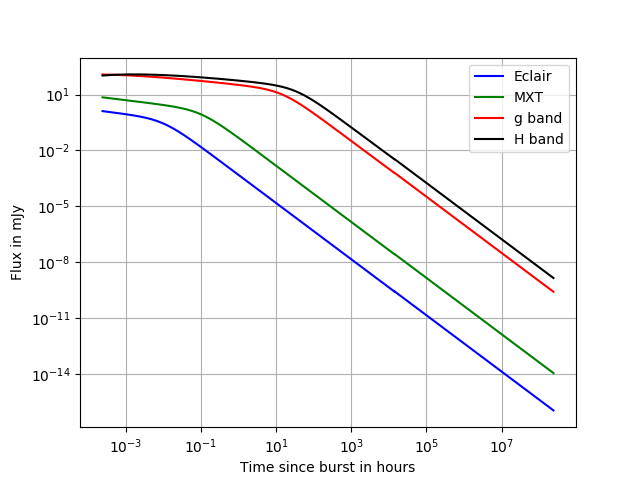

In [10]:
#Plot afterglow SED
plt.figure()
for i,wvl in enumerate(wavelength):
    plt.plot(time*24,afterglow_lc[:,i],label=labels[i],color=colors[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Time since burst in hours') 
plt.ylabel(r'Flux in mJy')
plt.grid(True)
plt.legend(loc='best')

# Adding IGM, dust and photoelectric absorption

You need to have install the los_extinction package to continue

In [11]:
from pyGRBaglow.reddening import reddening
from pyGRBaglow.igm import meiksin

In [12]:
wavelength=np.logspace(-7,12,1e4) #in angstroms
#wavelength=np.linspace(400,20000,1e4) #in angstroms

time = np.array([30/86400,10/1440,1/24,1]) # in days

frequencies = 3e8 / (wavelength*1e-10)

#Load object
afterglow=grb(n0, eps_b, eps_e, E_iso, eta, p, Y, redshift, ism_type, disp=0)
#Compute light curve for each time
afterglow_lc=afterglow.light_curve(time, frequencies, num_threads)

In [13]:
#Compute dust extinction in Host galaxy and Milky Way
trans_dust_host=reddening(wavelength, redshift, Av=0.39).Pei92(law='smc', Xcut=True)[1]
trans_dust_mw=reddening(wavelength, 0, Av=0.1).Pei92(law='mw', Xcut=True)[1]

In [14]:
#Compute gas extinction in Host galaxy and milky way
trans_photabs_host = reddening(wavelength,redshift, Av=0.2).gas_absorption(NHx=2)
trans_photabs_mw = reddening(wavelength, 0, Av=0.2).gas_absorption()

In [15]:
#Compute IGM transmission
trans_IGM=meiksin(wavelength/10, redshift, Xcut=True)

In [16]:
trans_total=trans_dust_host*trans_dust_mw*trans_photabs_host*trans_photabs_mw*trans_IGM

<IPython.core.display.Javascript object>


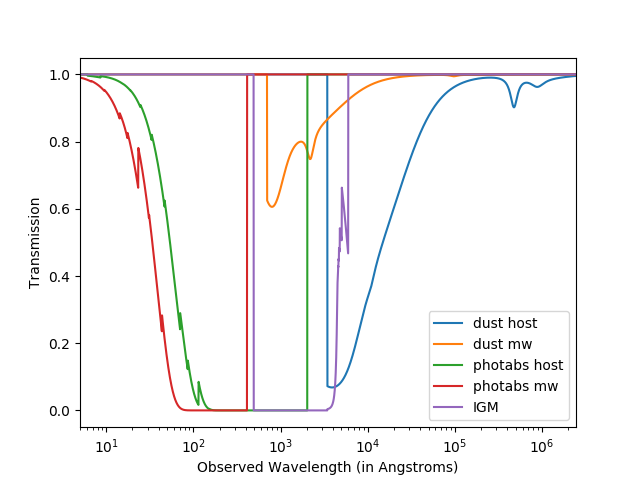

(5.0, 2460000.0)

In [17]:
plt.figure()
plt.plot(wavelength,trans_dust_host,label='dust host')
plt.plot(wavelength,trans_dust_mw,label='dust mw')
plt.plot(wavelength,trans_photabs_host,label='photabs host')
plt.plot(wavelength,trans_photabs_mw,label='photabs mw')
plt.plot(wavelength,trans_IGM,label='IGM')
plt.ylabel('Transmission')
plt.xlabel('Observed Wavelength (in Angstroms)')
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlim([5e0,5e5*(redshift+1)])

You can see the various cuts applied to allow a combined Xray + optical/NIR fit:
- Dust: transmission set to one below 700 angstroms x (1+z)
- IGM: transmission set to zero below 700 angstroms x (1+z) / set to one below 100 angstroms
- Photabs: transmission set to unity above 410 angstroms x (1+z) 

These are arbitrary values and might changed in the future if some misbehaviour are found

In [ ]:
labels=['30s','10m','1h','1j']
colors=['blue','green','red','black']

<IPython.core.display.Javascript object>


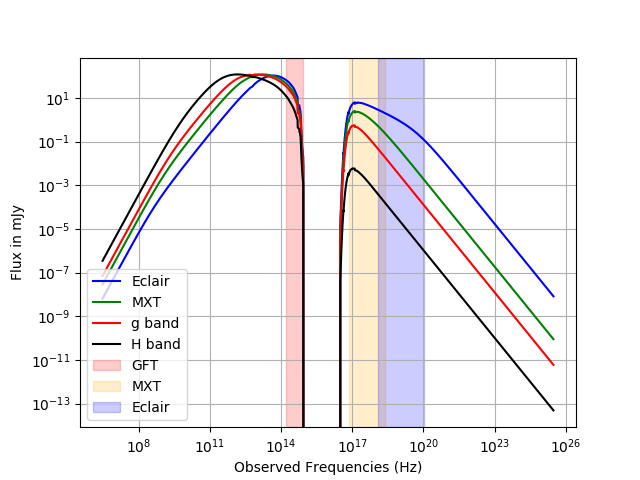

In [18]:
#Plot afterglow SED
plt.figure()
for i,t in enumerate(time):
    plt.plot(frequencies,afterglow_lc[i,:]*trans_total,label=labels[i],color=colors[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed Frequencies (Hz)') 
plt.ylabel(r'Flux in mJy')
#plt.ylim([1e-7,1e2])
#plt.xlim([1e2,1e3])
plt.grid(True)
plt.axvspan(cc.c_light_m_s*1e9/(350), cc.c_light_m_s*1e9/(1850),color='red', alpha=0.2,label="GFT")
plt.axvspan(0.3*1e3*cc.e_elec/(cc.H_planck), 10*1e3*cc.e_elec/(cc.H_planck), color='orange', alpha=0.2,label="MXT")
plt.axvspan(5e3*cc.e_elec/(cc.H_planck), 450e3*cc.e_elec/(cc.H_planck), color='blue', alpha=0.2,label="Eclair")

plt.legend(loc='lower left')
